In [2]:
import pandas as pd

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from keras .models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler


In [5]:
df = pd.read_csv("nse.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


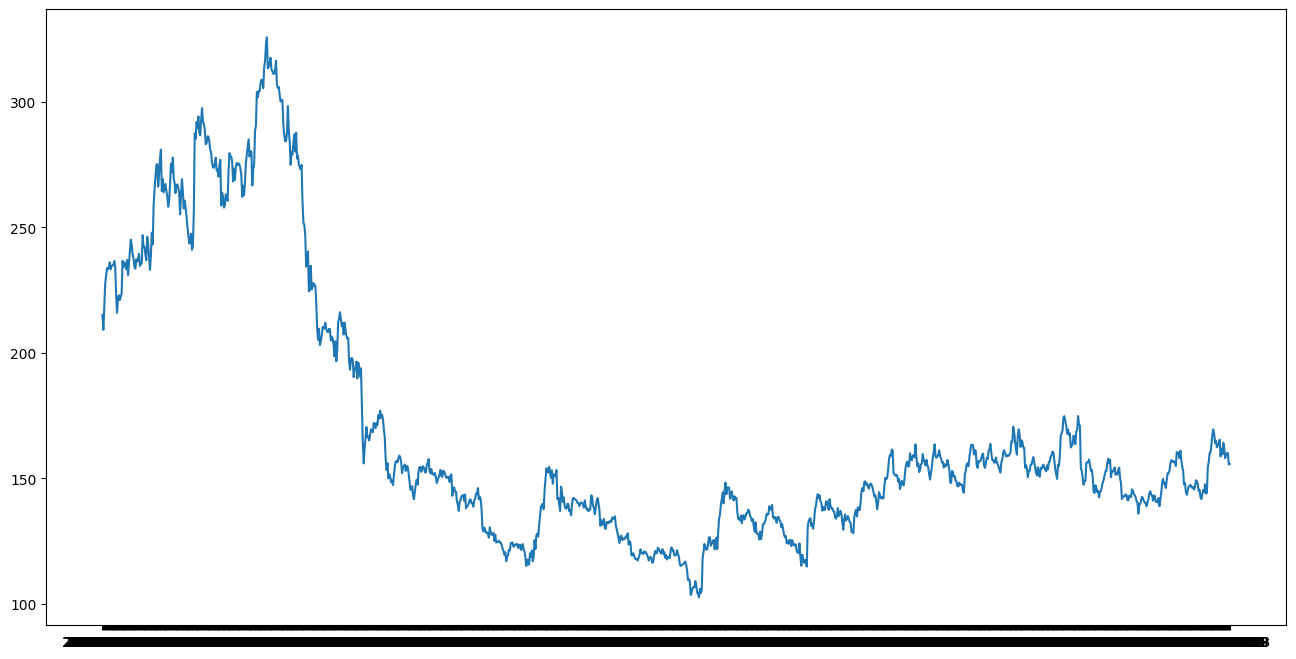

In [6]:
df["Data"] = pd.to_datetime(df.Date,format = "%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize = (16,8))
plt.plot(df["Close"],label='Close Price history')
                            

In [7]:
# Sort the dataframe by index in ascending order
data = df.sort_index(ascending=True, axis=0)

# Create a new DataFrame with the same length and required columns
new_dataset = pd.DataFrame(columns=['Date', 'Close'])

# Use .loc[] to avoid chained assignment issues
new_dataset["Date"] = data["Date"].values  # Copy Date column
new_dataset["Close"] = data["Close"].values  # Copy Close colum

In [17]:
# scaler=MinMaxScaler(feature_range=(0,1))
# final_dataset = new_dataset.values

# train_data=final_dataset[0:987,:]
# valid_data = final_dataset[987:,:]

# new_dataset.index = new_dataset.Date
# new_dataset.drop("Date",axis=1,inplace=True)
# scaler = MinMaxScaler(feature_range(0,1))
# scaled_data = scaler.fit_transform(final_dataset)

# x_train_data,y_train_data = [],[]

# for i in range(60,len(train_data)):
#     x_train_data.append(scaled_data[i-60:i,0])
#     y_train_data.append(scaled_data[i,0])


# x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
# x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset = new_dataset.values

In [9]:
train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

In [10]:
new_dataset.index = new_dataset["Date"]
new_dataset.drop("Date", axis=1, inplace=True)


In [11]:
# Ensure `new_dataset` only has numerical values before scaling
new_dataset.drop(columns=["Date"], inplace=True, errors='ignore')  # Remove 'Date' if it exists

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(new_dataset)  # Now it contains only numerical values

# Splitting the dataset
train_data = scaled_data[:987, :]
valid_data = scaled_data[987:, :]

# Creating training sequences
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])  # Last 60 values
    y_train_data.append(scaled_data[i, 0])  # Target value

# Convert to NumPy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape for LSTM
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [12]:
from keras.layers import Input

In [13]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))  # Explicit input layer
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(pd.DataFrame(inputs_data, columns=["Close"])) 

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')  # Fixed typo in loss function

# Train the model
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

927/927 - 39s - 42ms/step - loss: 9.8942e-04


In [14]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [15]:
lstm_model.save("model.keras")

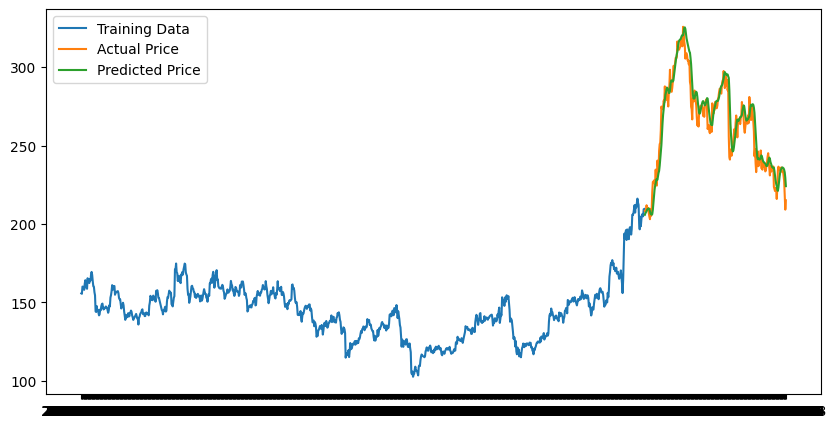

In [16]:
train_data = new_dataset[:987]  
valid_data = new_dataset[987:].copy()  # Make a copy to avoid SettingWithCopyWarning  

valid_data['Predictions'] = predicted_closing_price  

plt.figure(figsize=(10,5))  
plt.plot(train_data["Close"], label="Training Data")  
plt.plot(valid_data["Close"], label="Actual Price")  
plt.plot(valid_data["Predictions"], label="Predicted Price")  
plt.legend()  # Show legend  
plt.show()  # Display the plot  